In [1]:
import pickle
import numpy as np
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

---

In [29]:
prefix = "antikt-kt-test"

data = pickle.load(open("data/%s.pickle" % prefix, "rb"), encoding="latin1")
X, y = data

In [30]:
def convert(jet):
    constituents = jet["content"][jet["tree"][:, 0] == -1]
    content = np.zeros((len(constituents), 9))
    
    for i in range(len(constituents)):
        px = constituents[i, 0]
        py = constituents[i, 1]
        pz = constituents[i, 2]
        E = constituents[i, 3]

        p = (constituents[i, 0:3] ** 2).sum() ** 0.5
        eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
        theta = 2 * np.arctan(np.exp(-eta))
        pt = p / np.cosh(eta)
        phi = np.arctan2(py, px)

        content[i, 0] = p
        content[i, 1] = eta if np.isfinite(eta) else 0.0
        content[i, 2] = phi
        content[i, 3] = E
        content[i, 4] = pt if np.isfinite(pt) else 0.0
        content[i, 5] = theta if np.isfinite(theta) else 0.0
        content[i, 6] = px
        content[i, 7] = py
        content[i, 8] = pz
        
    return content

In [31]:
h5file = h5py.File("%s.h5" % prefix, mode="w")

for i, jet in enumerate(X):
    content = convert(jet)
    g = h5file.create_group("event_%d" % i)
    g.create_dataset("p", data=content[:, 0])
    g.create_dataset("eta", data=content[:, 1])
    g.create_dataset("phi", data=content[:, 2])
    g.create_dataset("E", data=content[:, 3])
    g.create_dataset("pt", data=content[:, 4])
    g.create_dataset("theta", data=content[:, 5])
    g.create_dataset("px", data=content[:, 6])
    g.create_dataset("py", data=content[:, 7])
    g.create_dataset("pz", data=content[:, 8])
    g.create_dataset("weight", data=1.0)
    
    g.attrs["jet_phi"] = jet["phi"]
    g.attrs["jet_pt"] = jet["pt"]
    g.attrs["jet_energy"] = jet["energy"]
    g.attrs["jet_eta"] = jet["eta"]
    g.attrs["jet_mass"] = jet["mass"]
    g.attrs["jet_length"] = len(content)
    g.attrs["label"] = y[i]

h5file.close()

---

In [4]:
X, y = pickle.load(open("data/antikt-kt-train-gcnn.pickle", "rb"), encoding='latin1')

In [5]:
def distances(jet, R=1.0, alpha=1.0):
    d = []
    for i in range(len(jet)):
        for j in range(i + 1, len(jet)):
            d_ij = min(jet[i, 4] ** (2 * alpha),
                       jet[j, 4] ** (2 * alpha))
            d_ij *= (jet[i, 1] - jet[j, 1]) ** 2 + (jet[i, 2] - jet[j, 2]) ** 2
            d_ij /= R
            d.append(d_ij)
    return np.array(d)

def weights(jet, beta=1.0):
    d_ij = distances(jet)
    dmin = np.min(d_ij)
    w_ij = np.exp(-beta * (d_ij - dmin) / dmin)
    return w_ij

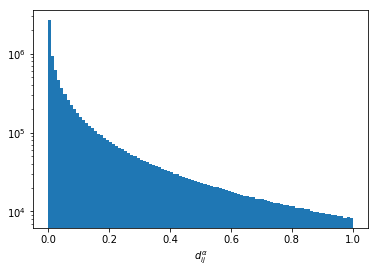

In [6]:
d = []
for i in range(5000):
    d.extend(distances(X[i]))

plt.hist(d, range=(0, 1.0), bins=100)
plt.yscale("log")
plt.xlabel(r"$d_{ij}^{\alpha}$")
plt.show()

In [15]:
d = []
for i in range(len(X)):
    d.append(np.min(distances(X[i])))

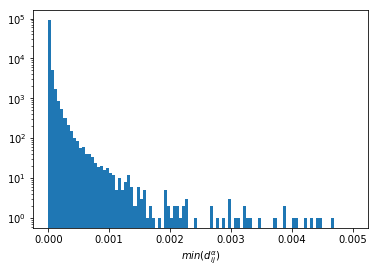

In [16]:
plt.hist(d, bins=100, range=(0, 0.005))
plt.yscale("log")
plt.xlabel(r"$min(d_{ij}^{\alpha})$")
plt.show()

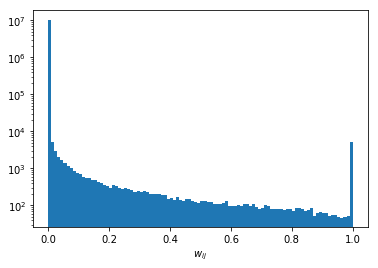

In [51]:
w = []
for i in range(5000):
    w.extend(weights(X[i]))
    
plt.hist(w, bins=100)
plt.yscale("log")
plt.xlabel(r"$w_{ij}$")
plt.show()